In [1]:
import os

import jax
import jax.numpy as jnp
import jax.random as jrand

import matplotlib.pyplot as plt
import numpy as np

/Users/grieser/Projects/alphagrad/src/alphagrad/eval/Encoder/A0_data


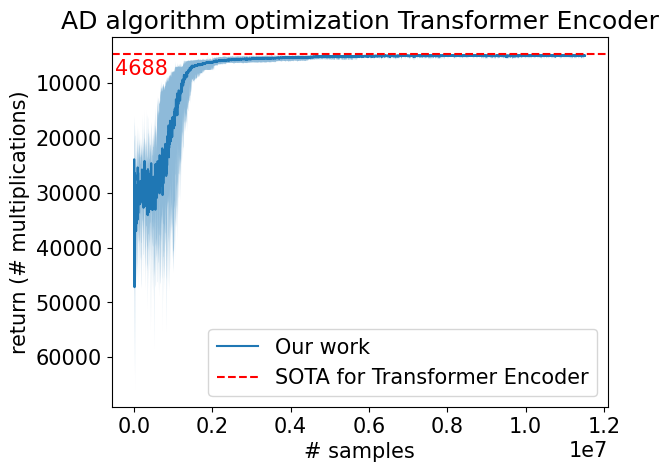

In [ ]:
font = {"family" : "normal",
        "weight" : "normal",
        "size"   : 15}

plt.rc("font", **font)

path = "PPO_data/" # "A0_data/" # 

runs = []
for file in os.listdir(path=os.path.join(os.getcwd(), path)):
				if file.endswith(".csv"):
								data = np.genfromtxt(os.path.join(os.getcwd(), path, file), delimiter=",", skip_header=1)
								num_samples = data[:4000, 0]*32*90 
								num_muls = -data[:4000, 1]
								runs.append(num_muls)

data = jnp.stack(runs, axis=0)

data_mean = jnp.mean(data, axis=0)
data_max = jnp.max(data, axis=0)
data_min	= jnp.min(data, axis=0)
data_err = jnp.stack([data_min, data_max], axis=0)

fig, ax = plt.subplots()
# ax.set_yscale("log")
ax.yaxis.set_inverted(True)
ax.plot(num_samples, data_mean, label="Our work")
ax.fill_between(num_samples, data_min, data_max, alpha=0.5)
ax.axhline(y=4688., color="r", linestyle="--", label="SOTA for Transformer Encoder")
ax.annotate("4688", (num_samples[0], 4688), textcoords="offset points", xytext=(5, -15), ha="center", color="red")
ax.set_xlabel("# samples")
ax.set_ylabel("return (# multiplications)")

ax.set_title("AD algorithm optimization Transformer Encoder")

ticks = ax.get_yticks()
labels = ax.get_yticklabels()
labels = [str(int(t)) for t in ticks]
ticks = ticks[::-1]
# ax.set_yticklabels(labels)
# ax.set_yticks(ticks)

ax.legend(loc="lower right")

In [2]:
from chex import Array
from tqdm import tqdm
import seaborn as sns
from timeit import default_timer as timer
from typing import Callable, Sequence
from graphax import jacve
from graphax.examples import Encoder

In [3]:
def measure_execution_time(f: Callable, 
                            args: Sequence[Array], 
                            order,
                            samplesize: int = 1000, 
                            print_results: bool = False) -> Sequence[int]:
    """
    TODO docstring
    """
    measurements = []
    argnums = list(range(len(args)))
    
    grad_f = ()
    in_axes = [0, 0] + [None]*(len(args)-2)
    # vmap_f = jax.vmap(f, in_axes=in_axes)
    # print(jax.make_jaxpr(vmap_f)(*[arg for arg in args]))
    grad_f = jax.jit(jacve(f, order=order, argnums=argnums))
    
    def measure(xs):
        st = timer()
        out = grad_f(*xs)
        jax.block_until_ready(out)
        dt = timer() - st
        return dt
        
    measurements = [measure([arg for arg in args])*1000 for i in tqdm(range(samplesize))]
    if print_results:
        print(measurements)
    
    plot = sns.histplot(measurements[1:], bins=50, stat="probability")
    fig = plot.get_figure()
    fig.savefig("./runtime_distribution.png")
    
    del measure
    del grad_f
    
    # Exclude first measurements due to JIT compilation
    return jnp.array(measurements[10:])

In [4]:
def measure_execution_time_with_jax(f: Callable, 
                                    args: Sequence[Array],
                                    samplesize: int = 1000) -> Sequence[int]:
    """
    TODO docstring
    """
    fwd_measurements, rev_measurements = [], []
    argnums = list(range(len(args)))
    in_axes = [None, None] + [0]*(len(args)-2)
    # vmap_f = jax.vmap(f, in_axes=in_axes)
    
    fwd_f = jax.jit(jax.jacfwd(f, argnums=argnums))
    rev_f = jax.jit(jax.jacrev(f, argnums=argnums))
    
    # print(grad_f(*[arg for arg in args]))
    def measure(xs):
        st = timer()
        out = fwd_f(*xs)
        jax.block_until_ready(out)
        dt = timer() - st
        return dt
        
    # fwd_measurements = [measure([arg for arg in args])*1000 for i in tqdm(range(samplesize))]
    fwd_measurements = jnp.zeros(128)
    def measure(xs):
        st = timer()
        out = rev_f(*xs)
        jax.block_until_ready(out)
        dt = timer() - st
        return dt
        
    rev_measurements = [measure([arg for arg in args])*1000 for i in tqdm(range(samplesize))]
    
    # Exclude first measurement due to JIT compilation
    return jnp.array(fwd_measurements[10:]), jnp.array(rev_measurements[10:])

In [5]:
def plot_performance_and_jax(f: Callable,
                    args: Sequence[Array],
                    order, 
                    mM_order,
                    fname: str,
                    samplesize: int = 1000,
                    quantiles: Array = jnp.array([0.025, 0.975]),
                    caption: str ="different modes") -> None:
    """
    TODO docstring
    """    
    cc_measurements = measure_execution_time(f, args, order, samplesize=samplesize)
    mM_measurements = measure_execution_time(f, args, mM_order, samplesize=samplesize)
    rev_measurements = measure_execution_time(f, args, "rev", samplesize=samplesize)
    fwd_measurements = measure_execution_time(f, args, "fwd", samplesize=samplesize)

    
    jax_fwd_measurements, jax_rev_measurements = measure_execution_time_with_jax(f, args, samplesize=samplesize)
    
    fwd_med = jnp.median(fwd_measurements)
    rev_med = jnp.median(rev_measurements)
    cc_med = jnp.median(cc_measurements)
    mM_med = jnp.median(mM_measurements)
    
    print(f"fwd mean: {fwd_med}, rev mean: {rev_med}, cc mean: {cc_med}, mM mean: {mM_med}")
    
    jax_fwd_med = jnp.median(jax_fwd_measurements)
    jax_rev_med = jnp.median(jax_rev_measurements)
    
    print(f"jax fwd mean: {jax_fwd_med}, jax rev mean: {jax_rev_med}")
    
    fwd_err = jnp.quantile(fwd_measurements, quantiles) - fwd_med
    rev_err = jnp.quantile(rev_measurements, quantiles) - rev_med
    cc_err = jnp.quantile(cc_measurements, quantiles) - cc_med
    mM_err = jnp.quantile(mM_measurements, quantiles) - mM_med
    
    print(f"fwd err: {fwd_err}, rev err: {rev_err}, cc err: {cc_err}, mM err: {mM_err}")
    
    jax_fwd_err = jnp.quantile(jax_fwd_measurements, quantiles) - jax_fwd_med
    jax_rev_err = jnp.quantile(jax_rev_measurements, quantiles) - jax_rev_med
    
    print(f"jax fwd err: {jax_fwd_err}, jax rev err: {jax_rev_err}")
    
    fig, ax = plt.subplots()
    
    plt.rcParams.update({"font.size": 15})  
    
    modes = ["fwd", "JAX fwd", "rev", "JAX rev", "cc", "mM"]
    x_pos = jnp.arange(0, len(modes))
    runtimes = jnp.stack([fwd_med, jax_fwd_med, rev_med, jax_rev_med, cc_med, mM_med])
    runtime_errors = jnp.stack([fwd_err, jax_fwd_err, rev_err, jax_rev_err, cc_err, mM_err], axis=1)*jnp.array([[-1.], [1.]])
    ax.bar(x_pos, runtimes, yerr=runtime_errors, align="center", alpha=0.5, 
            ecolor="black", color="#6096f6", capsize=10)
    
    ax.set_ylabel("Evaluation time [ms]", fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(modes, fontsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.set_title(f"Evaluation times of {caption}")
    ax.yaxis.grid(True)  
    # ax.set_ylim((0.025, 0.04))
    
    plt.tight_layout()
    # plt.savefig(fname)
    plt.show()

In [6]:
# 4656 mults
order = [60, 81, 8, 59, 58, 41, 69, 85, 1, 46, 25, 51, 37, 17, 56, 22, 12, 75, 
         78, 82, 7, 66, 47, 64, 20, 88, 65, 31, 38, 6, 63, 71, 87, 19, 90, 24, 
         80, 83, 27, 48, 77, 49, 29, 23, 76, 9, 79, 67, 61, 26, 89, 86, 18, 34, 
         39, 84, 74, 70, 30, 36, 35, 72, 50, 73, 68, 62, 57, 28, 5, 55, 13, 11, 
         54, 53, 43, 52, 45, 44, 42, 40, 33, 32, 21, 16, 15, 14, 3, 10, 4, 2]

mM_order = [7, 6, 8, 47, 46, 48, 81, 80, 82, 11, 16, 20, 21, 22, 25, 29, 31, 36, 
            51, 56, 60, 61, 62, 65, 69, 71, 75, 85, 88, 90, 89, 9, 12, 10, 26, 
            37, 38, 39, 49, 52, 50, 66, 76, 77, 78, 79, 83, 86, 84, 87, 24, 35, 
            64, 15, 55, 33, 74, 73, 4, 13, 17, 27, 34, 44, 53, 57, 67, 19, 59, 
            1, 2, 3, 18, 23, 41, 42, 43, 58, 63, 30, 70, 28, 68, 5, 45, 32, 14, 
            54, 72, 40]

  0%|          | 0/1010 [00:00<?, ?it/s]

Post: SparseTensor(
   shape = (64|64,64),
   out_dims = (SparseDimension(id=0, size=64, val_dim=None, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=64, val_dim=None, other_id=0), DenseDimension(id=2, size=64, val_dim=0)),
   val = Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = [],
   post_transforms = [])

Pre: SparseTensor(
   shape = (64,64|64,64),
   out_dims = (SparseDimension(id=0, size=64, val_dim=0, other_id=2), SparseDimension(id=1, size=64, val_dim=1, other_id=3)),
   primal_dims = (SparseDimension(id=2, size=64, val_dim=0, other_id=0), SparseDimension(id=3, size=64, val_dim=1, other_id=1)),
   val = Traced<ShapedArray(float32[64,64])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = [],
   post_transforms = [])

Post: SparseTensor(
   shape = (64|64,64),
   out_dims = (SparseDimension(id=0, size=64, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=64, val_dim=0, other_id=0), DenseDimension(id=

  0%|          | 0/1010 [00:00<?, ?it/s]

Post: SparseTensor(
   shape = (|),
   out_dims = (),
   primal_dims = (),
   val = None,
   pre_transforms = [JacobianTransform(transform=<function broadcast_elemental_rule.<locals>.broadcast_transform at 0x7f53b46aacb0>, inverse_transform=<function broadcast_elemental_rule.<locals>.inverse_broadcast_transform at 0x7f53b46ab2e0>)],
   post_transforms = [])

Pre: SparseTensor(
   shape = (64|64,64),
   out_dims = (SparseDimension(id=0, size=64, val_dim=None, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=64, val_dim=None, other_id=0), DenseDimension(id=2, size=64, val_dim=0)),
   val = Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = [],
   post_transforms = [])

Post: SparseTensor(
   shape = (64|64),
   out_dims = (SparseDimension(id=0, size=64, val_dim=None, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=64, val_dim=None, other_id=0),),
   val = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>,
   pre_t

  0%|          | 0/1010 [00:00<?, ?it/s]

Post: SparseTensor(
   shape = (32|32),
   out_dims = (SparseDimension(id=0, size=32, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=32, val_dim=0, other_id=0),),
   val = Traced<ShapedArray(float32[32])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = [],
   post_transforms = [])

Pre: SparseTensor(
   shape = (32|32,64),
   out_dims = (SparseDimension(id=0, size=32, val_dim=None, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=32, val_dim=None, other_id=0), DenseDimension(id=2, size=64, val_dim=0)),
   val = Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = [],
   post_transforms = [])

Post: SparseTensor(
   shape = (32|32,64),
   out_dims = (SparseDimension(id=0, size=32, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=32, val_dim=0, other_id=0), DenseDimension(id=2, size=64, val_dim=1)),
   val = Traced<ShapedArray(float32[32,64])>with<DynamicJaxprTrace(level=1/0)>,
   pre_trans

  0%|          | 0/1010 [00:00<?, ?it/s]

Post: SparseTensor(
   shape = (|),
   out_dims = (),
   primal_dims = (),
   val = None,
   pre_transforms = [JacobianTransform(transform=<function transpose_elemental_rule.<locals>.transpose_transform at 0x7f53b443b6d0>, inverse_transform=<function transpose_elemental_rule.<locals>.inverse_transpose_transform at 0x7f53b443aa70>)],
   post_transforms = [])

Pre: SparseTensor(
   shape = (64,64|64,64),
   out_dims = (SparseDimension(id=0, size=64, val_dim=None, other_id=2), DenseDimension(id=1, size=64, val_dim=0)),
   primal_dims = (SparseDimension(id=2, size=64, val_dim=None, other_id=0), DenseDimension(id=3, size=64, val_dim=1)),
   val = Traced<ShapedArray(float32[64,64])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = [],
   post_transforms = [])

Post: SparseTensor(
   shape = (|),
   out_dims = (),
   primal_dims = (),
   val = None,
   pre_transforms = [JacobianTransform(transform=<function transpose_elemental_rule.<locals>.transpose_transform at 0x7f53b443b6d0>, invers

100%|██████████| 1010/1010 [00:00<00:00, 1187.43it/s]


fwd mean: 21.38064956665039, rev mean: 0.2966430187225342, cc mean: 0.2888910174369812, mM mean: 16.174556732177734
jax fwd mean: 0.0, jax rev mean: 0.2867230176925659
fwd err: [-0.0646019  0.2172451], rev err: [-0.02311128  0.02165097], cc err: [-0.01980278  0.0213117 ], mM err: [-0.09164619  0.22754478]
jax fwd err: [0. 0.], jax rev err: [-0.02436703  0.02338374]


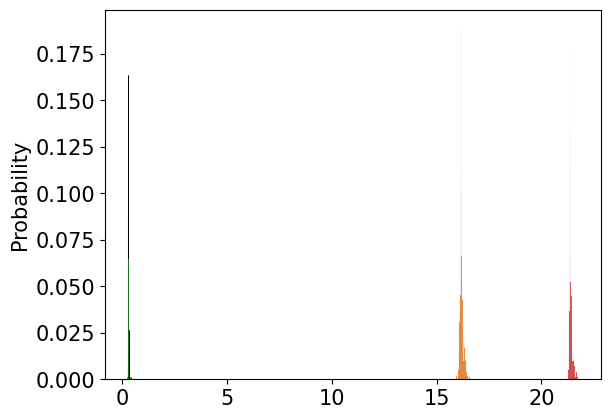

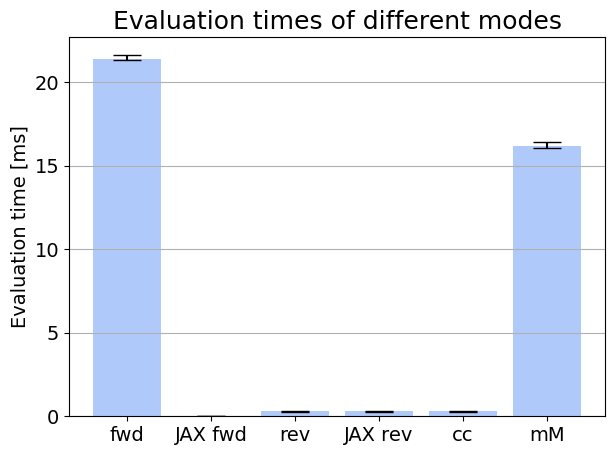

In [12]:
batchsize = 1
key = jrand.PRNGKey(1234)

scale_factor = 16

x = jnp.ones((scale_factor*4, scale_factor*4))
y = jrand.normal(key, (scale_factor*2, scale_factor*4))

wq1key, wk1key, wv1key, key = jrand.split(key, 4)
WQ1 = jrand.normal(wq1key, (scale_factor*4, scale_factor*4))
WK1 = jrand.normal(wk1key, (scale_factor*4, scale_factor*4))
WV1 = jrand.normal(wv1key, (scale_factor*4, scale_factor*4))

wq2key, wk2key, wv2key, key = jrand.split(key, 4)
WQ2 = jrand.normal(wq2key, (scale_factor*4, scale_factor*4))
WK2 = jrand.normal(wk2key, (scale_factor*4, scale_factor*4))
WV2 = jrand.normal(wv2key, (scale_factor*4, scale_factor*4))

w1key, w2key, b1key, b2key = jrand.split(key, 4)
W1 = jrand.normal(w1key, (scale_factor*4, scale_factor*4))
b1 = jrand.normal(b1key, (scale_factor*4,))

W2 = jrand.normal(w2key, (scale_factor*2, scale_factor*4))
b2 = jrand.normal(b2key, (scale_factor*2, 1))

xs = (x, y, WQ1, WQ2, WK1, WK2, WV1, WV2, W1, W2, b1, b2, 
      jnp.array([0.]), jnp.array([1.]), jnp.array([0.]), jnp.array([1.]))
plot_performance_and_jax(Encoder, xs, order, mM_order, "./Encoder.png", samplesize=1010)

### The best
CPU:
fwd mean: 760.6368408203125, rev mean: 29.666662216186523, cc mean: 28.72854232788086, mM mean: 317.65301513671875
jax fwd mean: 0.0, jax rev mean: 237.80465698242188
fwd err: [-53.30304  80.01019], rev err: [-4.0504646  1.3288574], cc err: [-3.7820683  1.3187199], mM err: [-19.343323  53.13864 ]
jax fwd err: [0. 0.], jax rev err: [-29.176987  13.248505]


GPU:
fwd mean: 999.1497802734375, rev mean: 10.977169036865234, cc mean: 10.651667594909668, mM mean: 495.98468017578125
jax fwd mean: 0.0, jax rev mean: 10.505422592163086
fwd err: [-22.966675  17.100586], rev err: [-1.0638933  0.8593893], cc err: [-0.98725986  0.43120956], mM err: [-6.701111 15.040314]
jax fwd err: [0. 0.], jax rev err: [-0.5466957   0.55638313]

In [7]:
def plot_performance_over_size_jax(f: Callable,
                                    args: Sequence[Array],
                                    order, 
                                    task: str,
                                    ticks: Sequence[int] = (2, 4, 8),
                                    samplesize: int = 1000,
                                    quantiles = jnp.array([0.025, 0.975])):
    
    cc_medians, cc_errs = [], []
    jax_fwd_medians, jax_fwd_errs = [], []
    jax_rev_medians, jax_rev_errs = [], []
    
    for arg in args:
        cc_measurements = measure_execution_time(f, arg, order, samplesize=samplesize)
        
        jax_fwd_measurements, jax_rev_measurements = measure_execution_time_with_jax(f, arg, samplesize=samplesize)
                
        cc_median = jnp.median(cc_measurements)
        jax_fwd_median = jnp.median(jax_fwd_measurements)
        jax_rev_median = jnp.median(jax_rev_measurements)
        
        cc_medians.append(cc_median)
        jax_fwd_medians.append(jax_fwd_median)
        jax_rev_medians.append(jax_rev_median)
                
        cc_errs.append(jnp.quantile(cc_measurements, quantiles) - cc_median)
        jax_fwd_errs.append(jnp.quantile(jax_fwd_measurements, quantiles) - jax_fwd_median)
        jax_rev_errs.append(jnp.quantile(jax_rev_measurements, quantiles) - jax_rev_median)
        
    _arr = jnp.array([[-1.], [1.]])
    jax_fwd_errs = jnp.stack(jax_fwd_errs, axis=1)*_arr
    jax_rev_errs = jnp.stack(jax_rev_errs, axis=1)*_arr
    cc_errs = jnp.stack(cc_errs, axis=1)*_arr
    
    jax_fwd_medians = jnp.array(jax_fwd_medians)
    jax_rev_medians = jnp.array(jax_rev_medians)
    cc_medians = jnp.array(cc_medians)
    
    font = {"family" : "normal",
												"weight" : "normal",
												"size"   : 15}

    plt.rc("font", **font)
    fig, ax = plt.subplots()
    x_pos = jnp.arange(len(args))
    # ax.errorbar(x_pos, jax_fwd_medians, yerr=jax_fwd_errs, label="JAX forward mode",
    #             fmt='.-', ecolor="black", elinewidth=1, capsize=3)
    ax.errorbar(x_pos, jax_rev_medians, yerr=jax_rev_errs, label="JAX reverse mode",
                fmt='.-', ecolor="black", elinewidth=1, capsize=3)
    
    ax.errorbar(x_pos, cc_medians, yerr=cc_errs, label="Graphax + AlphaGrad", 
                fmt='.-', ecolor="black", elinewidth=1, capsize=3, color="green")
    
    ax.set_yscale("log")
    ax.set_ylabel("Evaluation time in [ms]")
    ax.set_xlabel("Scale Factor")
    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(s) for s in ticks], fontsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.tick_params(axis="x", labelsize=14)
    ax.set_title(f"{task} evaluation times for different modes and batch sizes")
    ax.legend()
    ax.yaxis.grid(True)
    
    plt.tight_layout()
    plt.show()

in_axes [0, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


100%|██████████| 110/110 [00:00<00:00, 118.29it/s]


in_axes [0, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


100%|██████████| 110/110 [00:00<00:00, 125.27it/s]


in_axes [0, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


100%|██████████| 110/110 [00:00<00:00, 144.34it/s]


in_axes [0, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


100%|██████████| 110/110 [00:01<00:00, 97.92it/s]


in_axes [0, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


100%|██████████| 110/110 [00:02<00:00, 52.98it/s]


in_axes [0, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


100%|██████████| 110/110 [00:02<00:00, 40.55it/s]
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


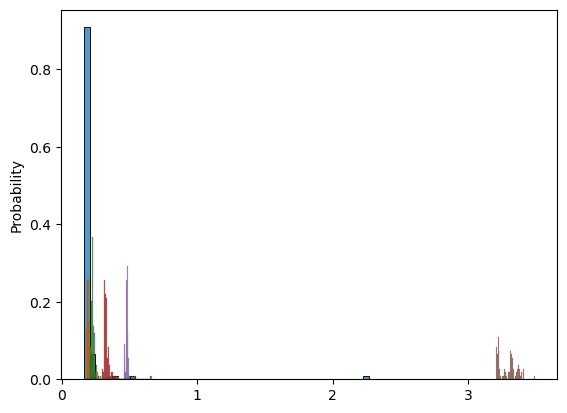

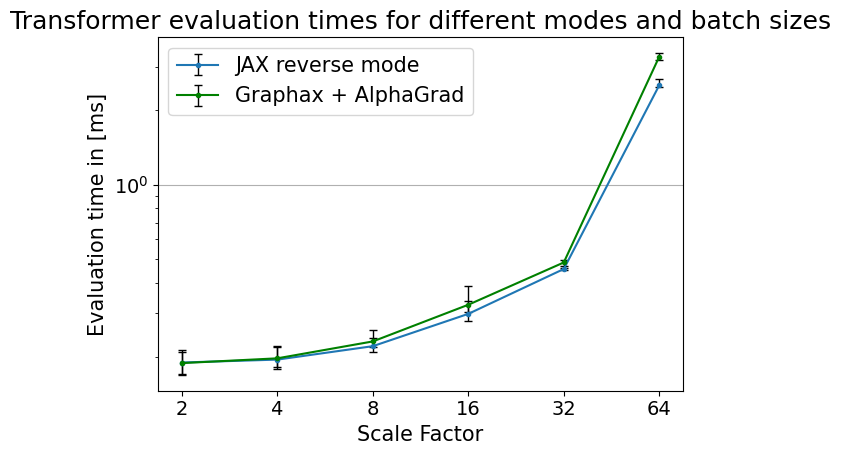

In [9]:
batchsize = 1
key = jrand.PRNGKey(1234)

xs = []
scale_factors = [2, 4, 8, 16, 32, 64]
for scale_factor in [2, 4, 8, 16, 32, 64]:
				x = jnp.ones((scale_factor*4, scale_factor*4))
				y = jrand.normal(key, (scale_factor*2, scale_factor*4))

				wq1key, wk1key, wv1key, key = jrand.split(key, 4)
				WQ1 = jrand.normal(wq1key, (scale_factor*4, scale_factor*4))
				WK1 = jrand.normal(wk1key, (scale_factor*4, scale_factor*4))
				WV1 = jrand.normal(wv1key, (scale_factor*4, scale_factor*4))

				wq2key, wk2key, wv2key, key = jrand.split(key, 4)
				WQ2 = jrand.normal(wq2key, (scale_factor*4, scale_factor*4))
				WK2 = jrand.normal(wk2key, (scale_factor*4, scale_factor*4))
				WV2 = jrand.normal(wv2key, (scale_factor*4, scale_factor*4))

				w1key, w2key, b1key, b2key = jrand.split(key, 4)
				W1 = jrand.normal(w1key, (scale_factor*4, scale_factor*4))
				b1 = jrand.normal(b1key, (scale_factor*4,))

				W2 = jrand.normal(w2key, (scale_factor*2, scale_factor*4))
				b2 = jrand.normal(b2key, (scale_factor*2, 1))

				_xs = (x, y, WQ1, WQ2, WK1, WK2, WV1, WV2, W1, W2, b1, b2, jnp.array([0.]), jnp.array([1.]), jnp.array([0.]), jnp.array([1.]))
				xs.append(_xs)

plot_performance_over_size_jax(Encoder, xs, order, "Transformer", ticks=scale_factors, samplesize=110)